In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import torch
from torch import nn
import torch
import time
from swyft.deps import UNet

import swyft
import pylab as plt
import scipy.stats.distributions as dist
from tqdm import tqdm

torch.set_float32_matmul_precision('medium')
DEVICE = "cuda"

### Generative model

In [27]:
class SimulatorBlob(swyft.Simulator):
    def __init__(self, bounds = None, Npix = 64, sigma = 0.1):
        super().__init__()
        self.transform_samples = swyft.to_numpy32
        self.theta_sampler = swyft.RectBoundSampler([dist.uniform(3.5, 1.00)])
        self.bounds = bounds
        self.Npix = Npix
        self.sigma = sigma
        self.powersampler = swyft.utils.PowerSpectrumSampler(Npix)
        self.sigma = torch.ones(Npix, Npix)*0.1
#        self.sigma[:,:Npix//2] *= 1000

    def get_pk_fn(self, theta):
        return lambda k: 1e6*3*(k/0.5+1)**-theta[0]
        
    def sample_delta(self, pk_fn):
        if self.bounds is not None:
            i = np.random.randint(len(self.bounds))
            return torch.tensor(self.bounds[i])
        else:
#            return self.powersampler.sample(lambda k: 1e6*3*(k/0.5)**-theta[0])
            return self.powersampler.sample(pk_fn)

    def psf(self, rho):
        return rho
            
    def build(self, graph):
        theta = graph.node("theta", self.theta_sampler)
        pk_fn = graph.node("pk_fn", self.get_pk_fn, theta)
        delta = graph.node("delta", self.sample_delta, pk_fn)
        rho = graph.node("rho", lambda delta: torch.exp(delta/5), delta)
        x = graph.node("x", lambda rho: self.psf(rho) + torch.randn(self.Npix, self.Npix)*self.sigma, rho)
#        z = graph.node("test", lambda: lambda x: x)

In [28]:
NPIX = 64
sim = SimulatorBlob(Npix = NPIX)
sample0 = sim.sample(conditions = dict(theta = np.array([4.])))

### Inference network

In [29]:
class Network(swyft.SwyftModule):
    def __init__(self, lr=1e-3, N = 1024):
        super().__init__()
        self.optimizer_init = swyft.AdamOptimizerInit(lr=1e-4, lrs_factor=0.1, lrs_patience=3)
        self.N = N
        L = lambda x: x*0
        self.Phi = lambda x: x
        self.PhiT = lambda x: x
        self.lre = swyft.LogRatioEstimator_Gaussian_Autoregressive_X_module_based(
            self.N**2, "mu", Phi = self.Phi, PhiT = self.PhiT, L = L, minstd = 1e-5, momentum=0.02)
        self.unet = UNet(1, 1, hidden_channels = 4)
    
    def embed(self, x):
        x = self.unet(x.unsqueeze(1)).squeeze(1) + x
        x = x.view(-1, self.N**2)
        return x

    def forward(self, A, B):
        N = self.N
        rhoA = self.embed(A['x'])
        rhoB = self.embed(B['x'])
        deltaB = B['delta'].view(-1, N**2)
        result = self.lre(rhoA, rhoB, deltaB)
        return result

### Inference

In [46]:
def round(bounds = None, max_epochs = 5, n_sims = 1000, gamma = 0.1, n_draws = 200, slope =4.):
    sim = SimulatorBlob(Npix = NPIX, bounds = bounds)
    samples = sim.sample(n_sims, exclude = ['pk_fn'])
    #net.cpu(); net.float()
    dm = swyft.SwyftDataModule(samples, fractions = [0.9, 0.1, 0.0], batch_size = 64)
    net = Network(N = NPIX)
    trainer = swyft.SwyftTrainer(accelerator = "gpu", devices = 1, max_epochs = max_epochs)
    trainer.fit(net, dm)
    
    GAMMA = gamma # 0.1 # 0.0001
    
    x = sample0['x']
    y = net.cuda().double().embed(torch.tensor(x).cuda().double().unsqueeze(0))[0]
    draws = []
    for _ in tqdm(range(n_draws)):
        pk = SimulatorBlob(Npix = NPIX).sample()['pk_fn']
        prior = sim.powersampler.get_prior_Q_factors(pk)
        prior = (prior[0], prior[1].cuda(), prior[2])
        x0 = net.lre.get_MAP(y, prior, gamma = GAMMA)
        draw = net.lre.get_noise_samples_GEDA(1, prior, steps = 300, reset = True, gamma = GAMMA)[0]
        draws.append(draw)
    draws = torch.stack(draws)
    
    bounds = [(x0.view(NPIX, NPIX).cpu().detach() + draws[i].view(NPIX, NPIX).cpu()).numpy() for i in range(len(draws))]
    bounds = np.array(bounds)
    
    v = 15
    plt.figure(figsize = (15, 5))
    for i in range(4):
        plt.subplot(2, 4, i+1)
        if i == 0:
            plt.imshow(sample0['delta'], cmap = 'seismic', vmin = -v, vmax = v)
        else:
            plt.imshow(bounds[i], vmin = -v, vmax = v, cmap = 'seismic')
        plt.colorbar()    
    res = [(x0.view(NPIX, NPIX).cpu().detach()*0 + draws[i].view(NPIX, NPIX).cpu()).numpy() for i in range(len(draws))]
    for i in range(4):
        plt.subplot(2, 4, i+1+4)
        plt.imshow(res[i], vmin = -v, vmax = v, cmap = 'seismic')
        plt.colorbar()
    plt.show()

    x = sample0['delta'].flatten()
    y = bounds.reshape(-1, NPIX**2)
    ym = y.mean(axis=0)
    ys = y.std(axis=0)
    plt.scatter(x, ym)
    plt.scatter(x, x)
    plt.show()

    diff = ((y-x)/ys).flatten()
    plt.hist(diff, bins = 100)
    plt.show()
    p = np.percentile(diff, [2.5, 16, 50, 84, 97.5])
    print("Residual percentiles:", p)

    pks = swyft.utils.get_pk(torch.tensor(bounds))
    clean_sims = SimulatorBlob().sample(100)['delta']
    pks2 = swyft.utils.get_pk(torch.tensor(clean_sims))
    pks3 = swyft.utils.get_pk(torch.tensor(sample0['delta']))
    plt.plot([], '0.5', alpha = 0.5, label = "Unconstrained")
    plt.plot([], 'r', alpha = 0.5, label = "Constrained")
    plt.semilogy(pks2.T, '0.5', alpha = 0.5);
    plt.semilogy(pks.T, 'r', alpha = 0.5);
    plt.semilogy(pks3.T, 'y', label = "Truth");
    plt.legend()
    plt.show()

    return bounds

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2007.28it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type                                                     | Params
----------------------------------------------------------------------------------
0 | lre  | LogRatioEstimator_Gaussian_Autoregressive_X_module_based | 0     
1 | unet | UNet                                                     | 1.9 M 
----------------------------------------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.769     Total estimated model params size (MB)


Epoch 0:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████▋             | 15/17 [00:00<00:00, 18.88it/s, loss=-141, v_num=96]
Validation: 0it [00:00, ?it/s]
Epoch 1:  88%|██████████████████████████████████████████████████████████████████████████████▌          | 15/17 [00:00<00:00, 15.17it/s, loss=-2.24e+03, v_num=96, val_loss=-2.59e+3]
Validation: 0it [00:00, ?it/s]
Epoch 2:  88%|██████████████████████████████████████████████████████████████████████████████▌          | 15/17 [00:00<00:00, 17.56it/s, loss=-3.01e+03, v_num=96, val_loss=-3.38e+3]
Validation: 0it [00:00, ?it/s]
Epoch 3:  88%|██████████████████████████████████████████████████████████████████████████████▌          | 15/17 [00:00<00:00, 16.06it/s, loss=-3.42e+03, v_num=96, val_loss=-3.76e+3]
Validation: 0it [00:00, ?it/s]
Epoch 4:  88%|███████████████████████████████████████████████████████████████████████████████▍          | 15/17 [00:00<00:00, 16.63it/s, loss=-3.7e+03, 

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 17.64it/s, loss=-5.3e+03, v_num=96, val_loss=-5.19e+3]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:40<00:00,  3.00it/s]


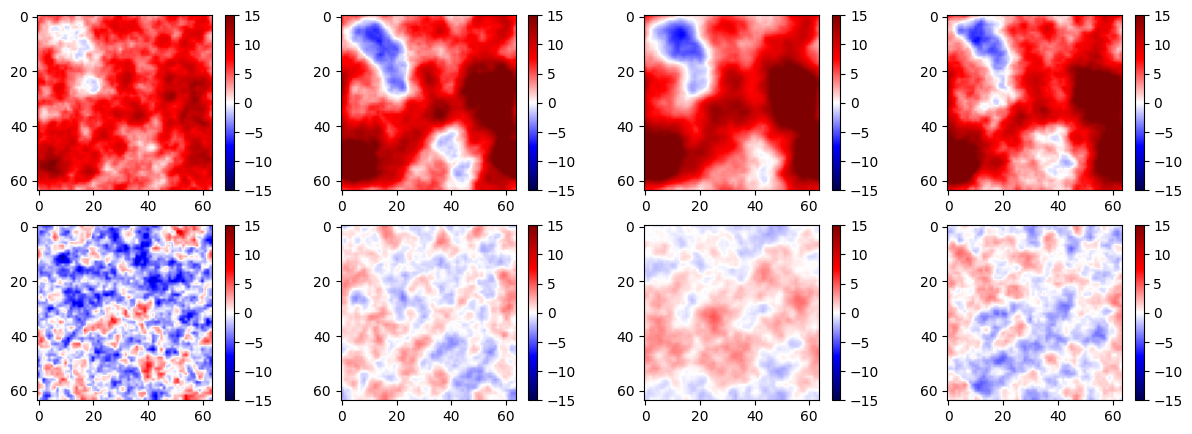

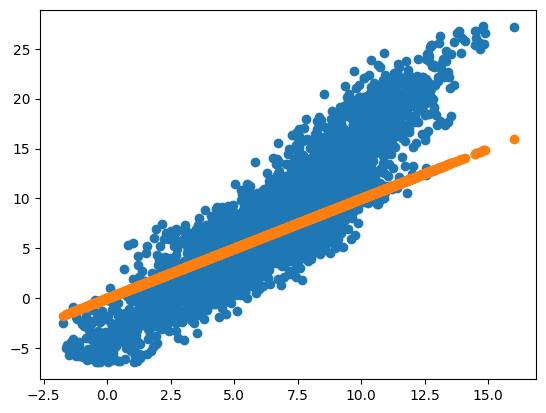

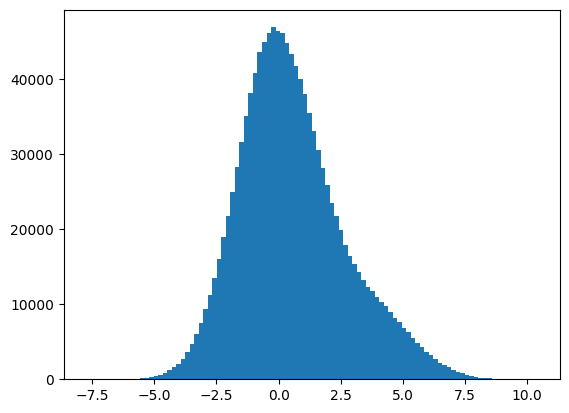

Residual percentiles: [-3.05830749 -1.45773017  0.31042179  2.6840846   5.45078769]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1289.66it/s]


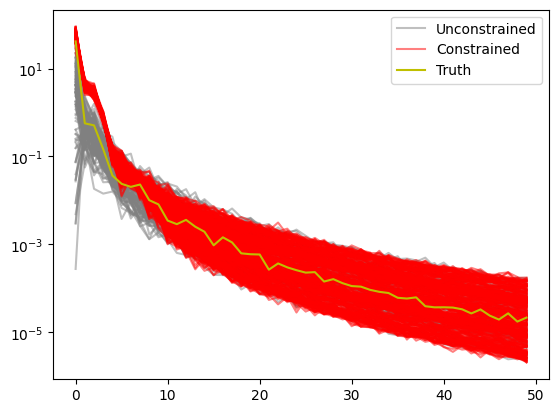

In [49]:
bounds = None
bounds = round(bounds = bounds, max_epochs = 15, n_draws = 300, gamma = 1e-2)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3615.48it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type                                                     | Params
----------------------------------------------------------------------------------
0 | lre  | LogRatioEstimator_Gaussian_Autoregressive_X_module_based | 0     
1 | unet | UNet                                                     | 1.9 M 
----------------------------------------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.769     Total estimated model params size (MB)


Epoch 0:  88%|███████████████████████████████████████████████████████████████████████████████████████████████▎            | 15/17 [00:00<00:00, 15.78it/s, loss=-3.07e+03, v_num=97]
Validation: 0it [00:00, ?it/s]
Epoch 1:  88%|███████████████████████████████████████████████████████████████████████████████▍          | 15/17 [00:00<00:00, 17.84it/s, loss=-4.02e+03, v_num=97, val_loss=-4.1e+3]
Validation: 0it [00:00, ?it/s]
Epoch 2:  88%|██████████████████████████████████████████████████████████████████████████████▌          | 15/17 [00:00<00:00, 19.63it/s, loss=-4.43e+03, v_num=97, val_loss=-4.29e+3]
Validation: 0it [00:00, ?it/s]
Epoch 3:  88%|███████████████████████████████████████████████████████████████████████████████▍          | 15/17 [00:00<00:00, 15.65it/s, loss=-4.65e+03, v_num=97, val_loss=-4.4e+3]
Validation: 0it [00:00, ?it/s]
Epoch 4:  88%|██████████████████████████████████████████████████████████████████████████████▌          | 15/17 [00:00<00:00, 17.52it/s, loss=-4.81e+03, 

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 18.16it/s, loss=-5.6e+03, v_num=97, val_loss=-4.89e+3]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:18<00:00,  3.84it/s]


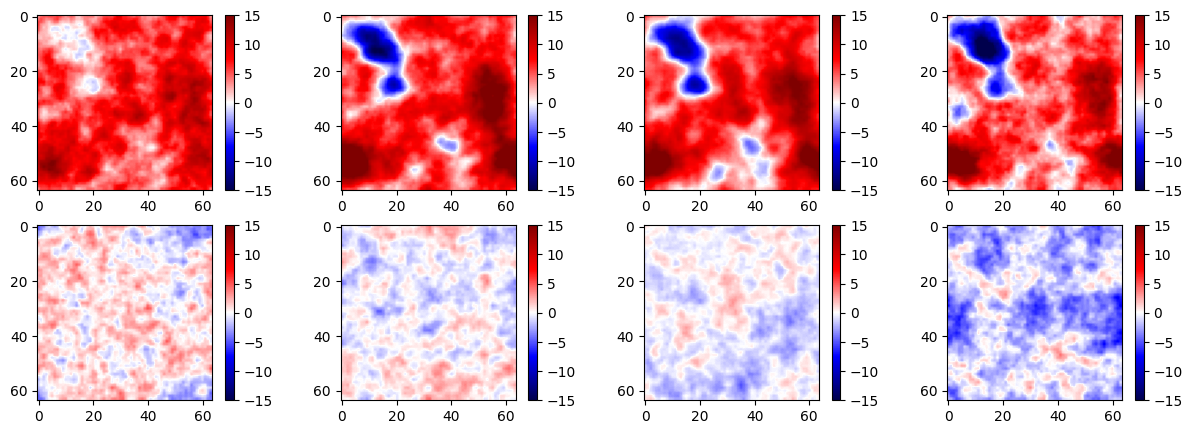

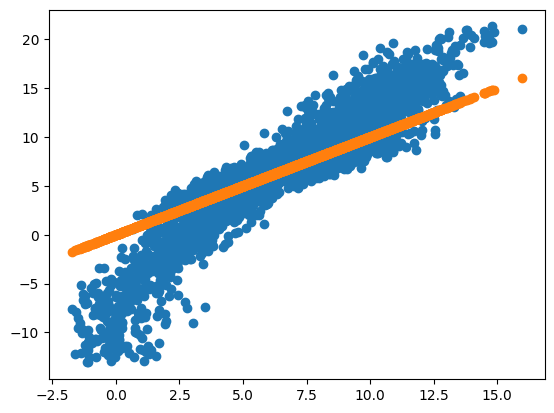

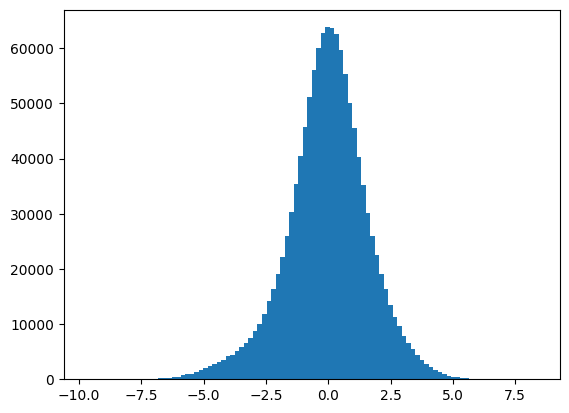

Residual percentiles: [-3.70586427 -1.48959913  0.01394885  1.45213104  3.14135345]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1869.73it/s]


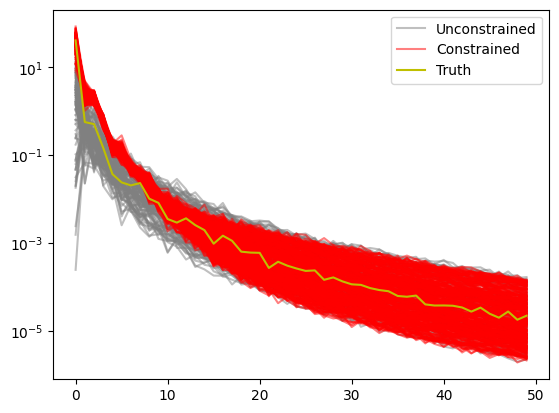

In [50]:
bounds = round(bounds = bounds, max_epochs = 15, n_draws = 300, gamma = 1e-2)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3171.30it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type                                                     | Params
----------------------------------------------------------------------------------
0 | lre  | LogRatioEstimator_Gaussian_Autoregressive_X_module_based | 0     
1 | unet | UNet                                                     | 1.9 M 
----------------------------------------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.769     Total estimated model params size (MB)


Epoch 0:  88%|███████████████████████████████████████████████████████████████████████████████████████████████▎            | 15/17 [00:00<00:00, 19.25it/s, loss=-3.45e+03, v_num=98]
Validation: 0it [00:00, ?it/s]
Epoch 1:  88%|██████████████████████████████████████████████████████████████████████████████▌          | 15/17 [00:00<00:00, 16.68it/s, loss=-4.02e+03, v_num=98, val_loss=-4.31e+3]
Validation: 0it [00:00, ?it/s]
Epoch 2:  88%|███████████████████████████████████████████████████████████████████████████████▍          | 15/17 [00:01<00:00, 14.94it/s, loss=-4.3e+03, v_num=98, val_loss=-4.54e+3]
Validation: 0it [00:00, ?it/s]
Epoch 3:  88%|██████████████████████████████████████████████████████████████████████████████▌          | 15/17 [00:00<00:00, 19.88it/s, loss=-4.46e+03, v_num=98, val_loss=-4.66e+3]
Validation: 0it [00:00, ?it/s]
Epoch 4:  88%|██████████████████████████████████████████████████████████████████████████████▌          | 15/17 [00:00<00:00, 16.78it/s, loss=-4.58e+03, 

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:01<00:00, 15.97it/s, loss=-5.71e+03, v_num=98, val_loss=-5.64e+3]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:20<00:00,  3.71it/s]


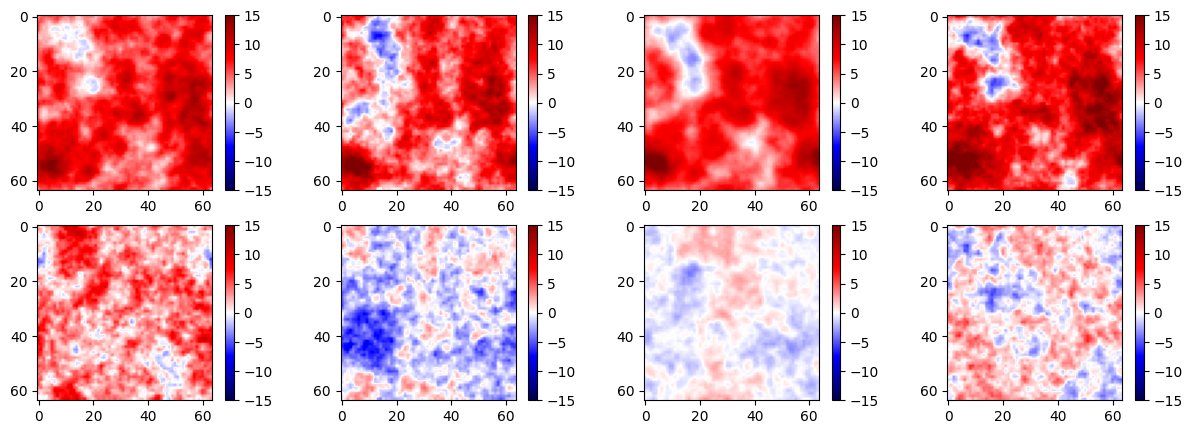

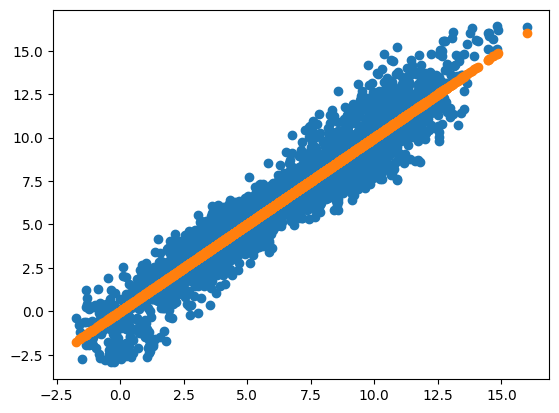

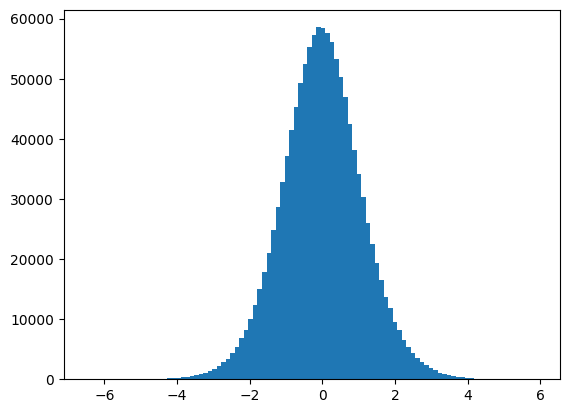

Residual percentiles: [-2.19455182 -1.06713088 -0.0183029   1.04806815  2.22591934]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1897.82it/s]


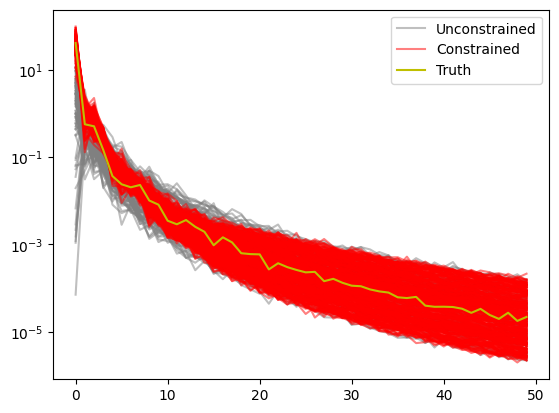

In [51]:
bounds = round(bounds = bounds, max_epochs = 15, n_draws = 300, gamma = 1e-2)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3026.18it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type                                                     | Params
----------------------------------------------------------------------------------
0 | lre  | LogRatioEstimator_Gaussian_Autoregressive_X_module_based | 0     
1 | unet | UNet                                                     | 1.9 M 
----------------------------------------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.769     Total estimated model params size (MB)


Epoch 0:  88%|███████████████████████████████████████████████████████████████████████████████████████████████▎            | 15/17 [00:00<00:00, 19.19it/s, loss=-3.18e+03, v_num=99]
Validation: 0it [00:00, ?it/s]
Epoch 1:  88%|██████████████████████████████████████████████████████████████████████████████▌          | 15/17 [00:00<00:00, 16.39it/s, loss=-3.87e+03, v_num=99, val_loss=-4.58e+3]
Validation: 0it [00:00, ?it/s]
Epoch 2:  88%|██████████████████████████████████████████████████████████████████████████████▌          | 15/17 [00:00<00:00, 18.47it/s, loss=-4.28e+03, v_num=99, val_loss=-4.81e+3]
Validation: 0it [00:00, ?it/s]
Epoch 3:  88%|██████████████████████████████████████████████████████████████████████████████▌          | 15/17 [00:00<00:00, 18.00it/s, loss=-4.57e+03, v_num=99, val_loss=-4.95e+3]
Validation: 0it [00:00, ?it/s]
Epoch 4:  88%|██████████████████████████████████████████████████████████████████████████████▌          | 15/17 [00:00<00:00, 17.93it/s, loss=-4.85e+03, 

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:01<00:00, 15.99it/s, loss=-6.27e+03, v_num=99, val_loss=-6.24e+3]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:11<00:00,  4.20it/s]


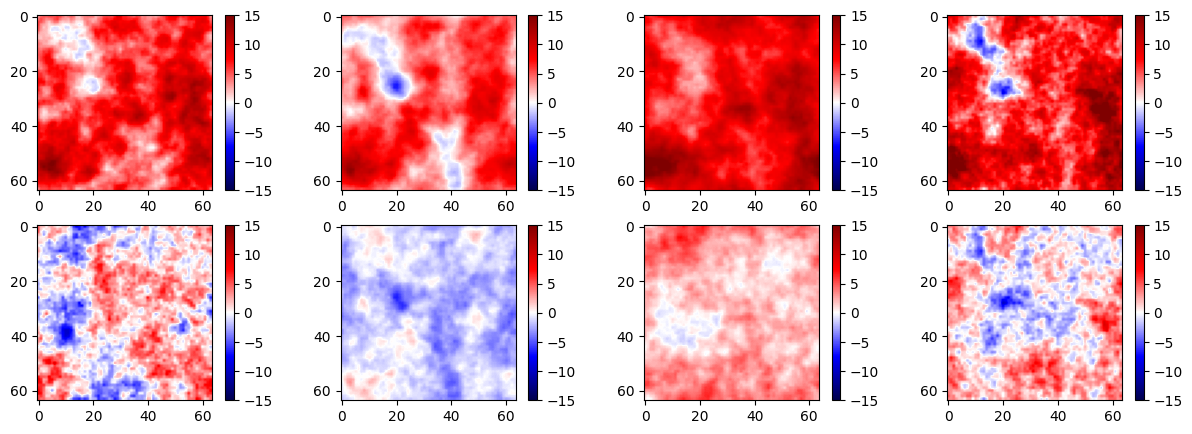

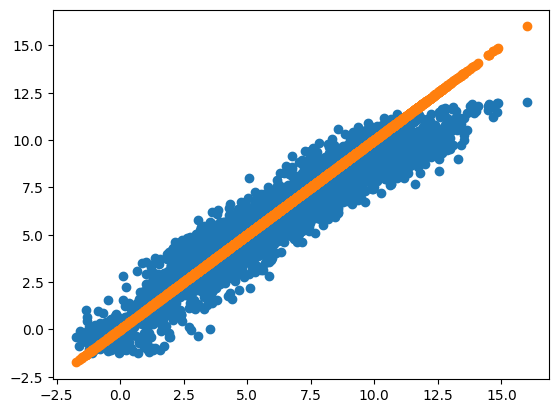

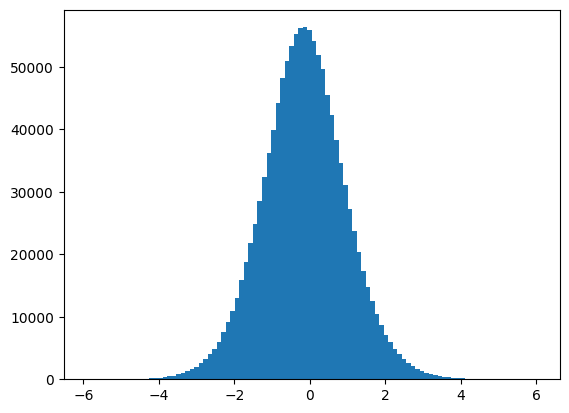

Residual percentiles: [-2.3219065  -1.20361179 -0.15395706  0.91032962  2.07201301]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1644.03it/s]


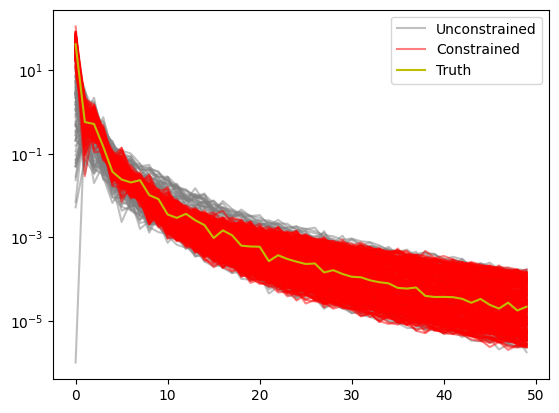

In [52]:
bounds = round(bounds = bounds, max_epochs = 15, n_draws = 300, gamma = 1e-2)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3078.54it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type                                                     | Params
----------------------------------------------------------------------------------
0 | lre  | LogRatioEstimator_Gaussian_Autoregressive_X_module_based | 0     
1 | unet | UNet                                                     | 1.9 M 
----------------------------------------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.769     Total estimated model params size (MB)


Epoch 0:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▍            | 15/17 [00:00<00:00, 18.54it/s, loss=-3.57e+03, v_num=100]
Validation: 0it [00:00, ?it/s]
Epoch 1:  88%|██████████████████████████████████████████████████████████████████████████████▌          | 15/17 [00:00<00:00, 16.08it/s, loss=-4.17e+03, v_num=100, val_loss=-4.3e+3]
Validation: 0it [00:00, ?it/s]
Epoch 2:  88%|█████████████████████████████████████████████████████████████████████████████▋          | 15/17 [00:01<00:00, 14.07it/s, loss=-4.52e+03, v_num=100, val_loss=-4.69e+3]
Validation: 0it [00:00, ?it/s]
Epoch 3:  88%|█████████████████████████████████████████████████████████████████████████████▋          | 15/17 [00:00<00:00, 16.72it/s, loss=-4.82e+03, v_num=100, val_loss=-4.92e+3]
Validation: 0it [00:00, ?it/s]
Epoch 4:  88%|██████████████████████████████████████████████████████████████████████████████▌          | 15/17 [00:00<00:00, 16.16it/s, loss=-5.1e+03, v

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:01<00:00, 15.74it/s, loss=-6.4e+03, v_num=100, val_loss=-6.37e+3]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:37<00:00,  7.97it/s]


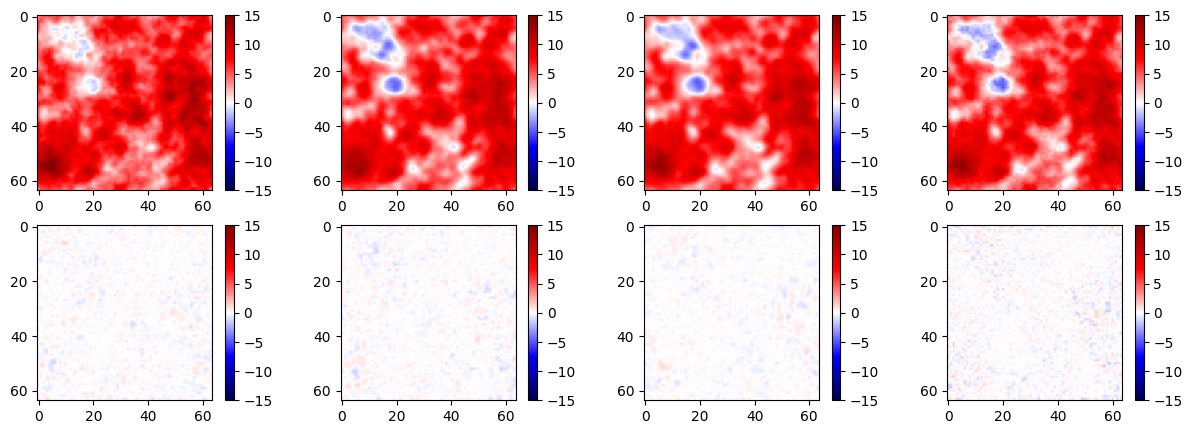

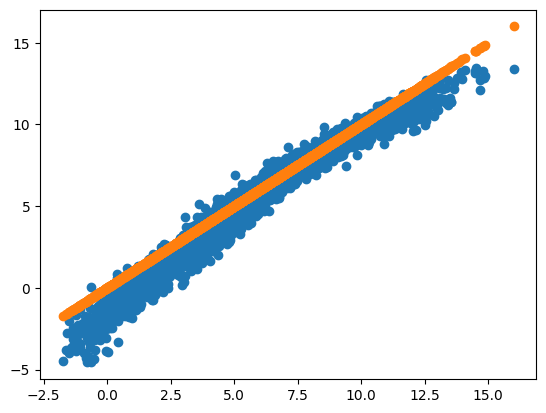

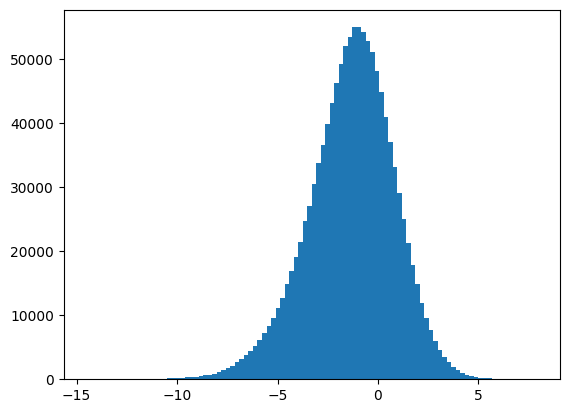

Residual percentiles: [-5.9884557  -3.41129606 -1.20624672  0.72054206  2.54954229]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2146.24it/s]


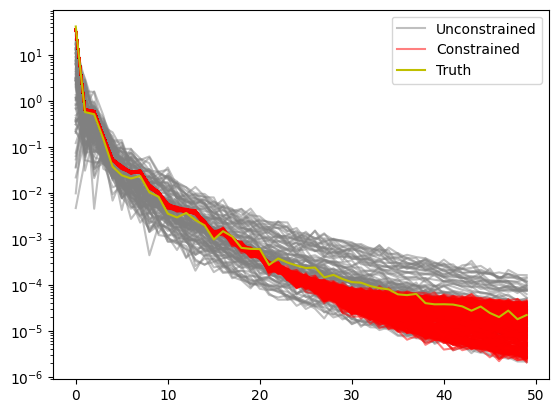

In [53]:
bounds = round(bounds = bounds, max_epochs = 15, n_draws = 300, gamma = 1e0)